In [1]:
%run ./Scripts/mklib.py
%run ./Scripts/mk_models.py

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
from ipywidgets import Checkbox, IntSlider

import matplotlib as mpl
import pickle

import sc2reader
from sc2reader.engine.plugins import APMTracker, SelectionTracker
sc2reader.engine.register_plugin(APMTracker())
sc2reader.engine.register_plugin(SelectionTracker())


In [2]:
sns.set_palette([(0.29803921568627451, 0.44705882352941179, 0.69019607843137254),
 (0.33333333333333331, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.30588235294117649, 0.32156862745098042),
 (0.80000000000000004, 0.72549019607843135, 0.45490196078431372),
 (0.39215686274509803, 0.70980392156862748, 0.80392156862745101)])

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 14,
         'axes.labelsize': 14,
         'axes.titlesize':20}
pylab.rcParams.update(params)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('seaborn-white')



pd.options.display.max_columns = 150

In [ ]:
cell_width(98)
code_toggle()

In [ ]:
%%time
games_IEM = []
for game in sc2reader.load_replays('./../../../Games/IEM XI - World Championship - StarCraft II Replays/', load_level = 3):
    games_IEM.append(game)

## StarCraft II<br>Understanding adversarial human behaviour in games of skill and information asymmetry.

### by Mycchaka Kleinbort


## Introduction

Checkers, Chess, Backgamon, Jeperdy, Go..

It is perhaps inevitable that any game played by humans will eventualy become the subject of ongoing A.I. research. The framework of games - rules and objectives - is inherently suited to systematic study, and their ever increasing complexity has motivated a seemingly endless stream of new tools and insights.


<right><img src="./../../../../Desktop/Games and AI timeline.png" style=" margin: 5px; width: 1080px"></right>

In November of 2016 Google DeepMind - in partnership with Blizzard entertainment - anounced their intention to make Starcraft 2 the focus of further A.I. research. In this project we seek to compile and explore the currently available data, to extract and infer features that can qualify a player's performance, and to validate these features by building several predictive models.


## Index
- [Introduction](#intro)
- [Objectives](#objectives)<br>- [Principal objective](#objectives1)<br>- [Auxiliary objectives](#objectives2)
- [Term vector model visual example](#term-vector-ex)

## Objectives

### Principal objective
>The game lasted for 73 moves but eventually Deep Blue's operator had to resign the game for the computer in a position where both players had a bishop but Kasparov had three pawns to Deep Blue's one.
<br>
><div style="color:gray ; text-align: left">_Kasparov vs Deep Blue - Game 2, 1996_</div>

In theory a StarCraft game ends when all building and units of a player have been destroyed. However, much like in chess, experienced players know when it's over and surrender. Our first goal is to build a predictive model that can anticipate a player's surrender based on the game's current state, thereby predicting the winner with increasing certainty as the game progresses. Explicitly, we seek to build a function f such that

    f(player, Game State at T) = P(player eventualy concedes | GameState at T)

Although some human psychology does come into play, we will **not** delve into an analysis of morale and confidence. We conceive of the game as a Markov chain and as such the future of the game is fully captured by its current state.



### Auxiliary objectives

We will also seek to investigate the relationship between the current game state and the time until the game terminates. Explicitly, we seek to build a function g such that

    g(Game State at T) = pdf(Game End Time | Game State at T)

Our final goal will be to create a function

    h(Game State at T) = pdf(Player concedes at t | Game State at T)

### Units in SC2

As mentioned above, players can choose one of 3 races to comand, these are:

- Terrans (Space humans)
- Zergs (Space insects)
- Protoss (Space wizards)

Each have their own units, buildings, technologies and playstyles.

If we concentrate for now on the units each race have at their disposal we may find the following table useful.

In [4]:
unit_attributes_df = pd.read_pickle('./Resources/unit_attributes.p')
unit_attributes_df.head()

,Unit,Mineral,Vespene,Supply,Build Time,Build From,Life,Shields,Energy,Armor,Race,Flying
0,SCV,50,0,1,17,Command Center,45,0,0,0,Terran,False
1,Marine,50,0,1,25,Barracks,45,0,0,0,Terran,False
2,Marauder,100,25,2,30,Barracks,125,0,0,1,Terran,False
3,Reaper,50,50,1,45,Barracks,60,0,0,0,Terran,False
4,Ghost,200,100,2,40,Barracks,100,0,200,0,Terran,False


Of the two currencies used to train units, vespene gas is a tougher resource to obtain, with a player's gas imcome very rarely eceeding 25% that of their mineral income.

As a rule of thumb, more expensive units are better, but a mid tier unit early in the game can often be better value than a delayed top tier unit, and many low tier units may close a game if used effectively during the first minutes of a match.

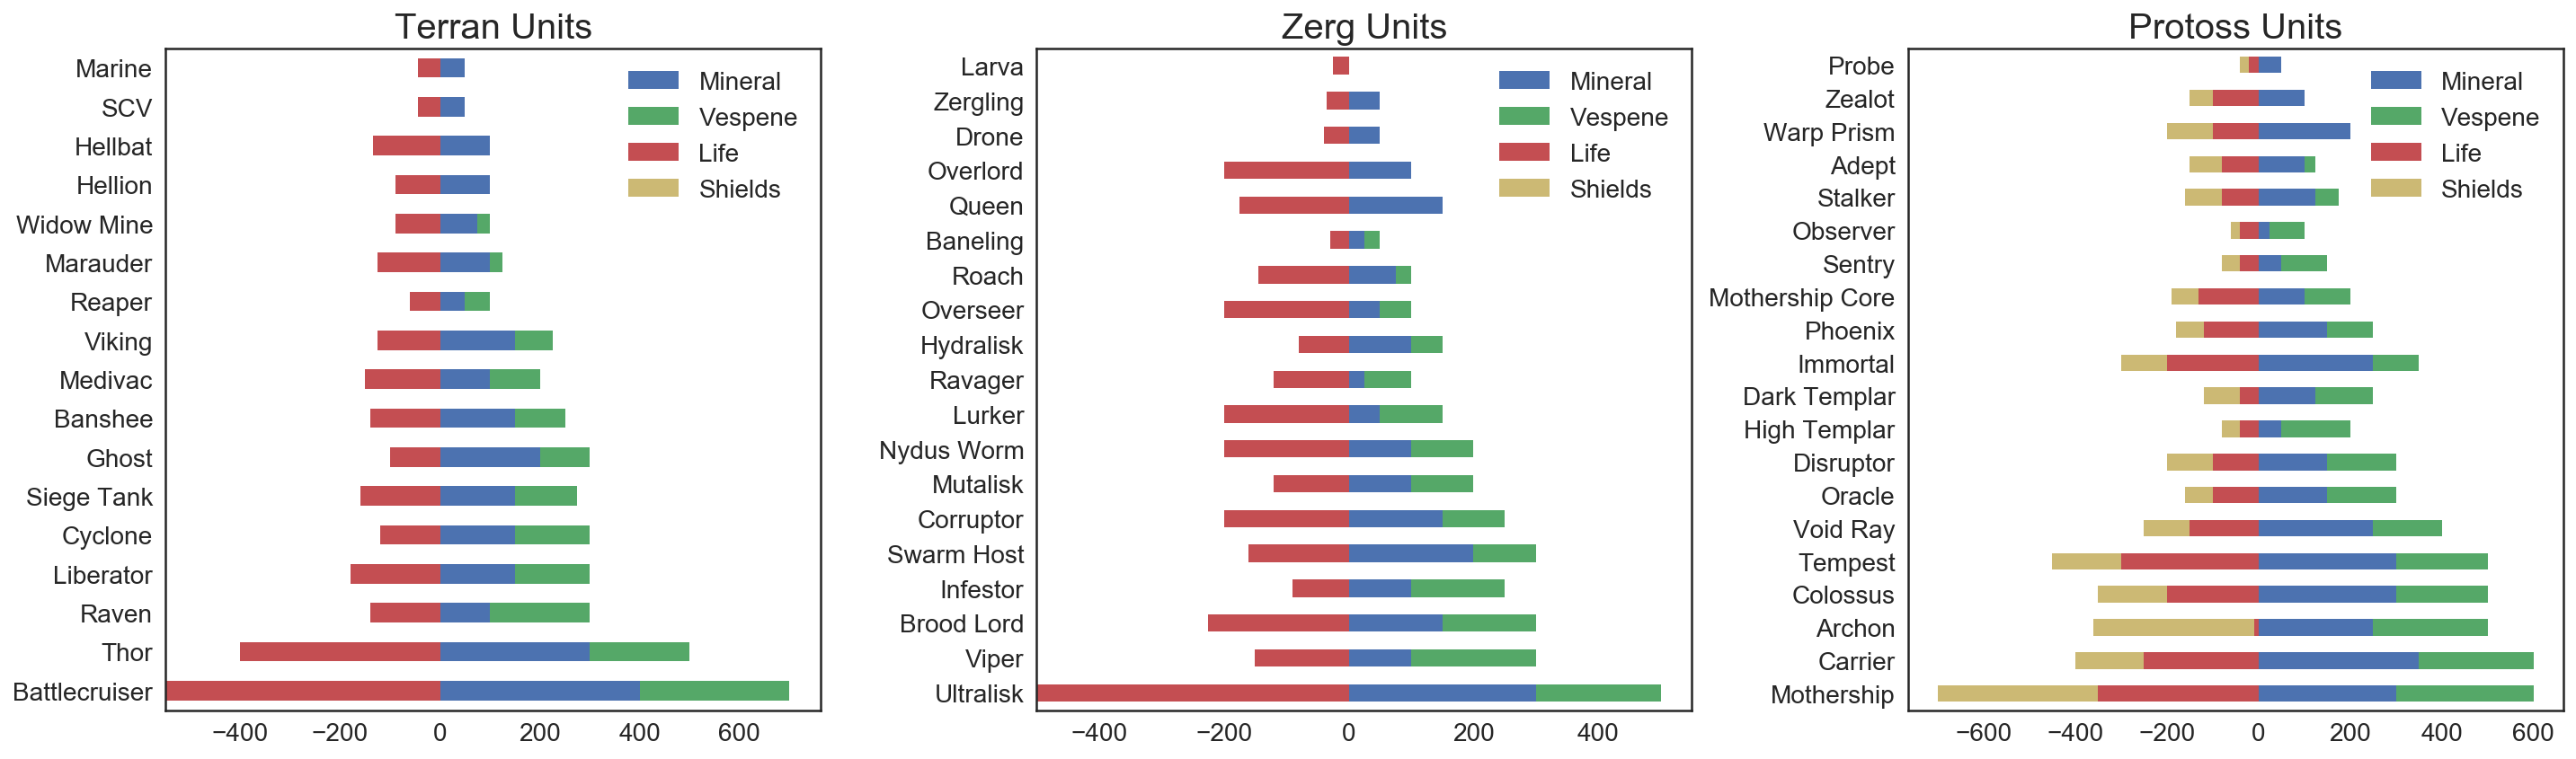

In [5]:
df = unit_attributes_df.sort_values(by = ['Vespene','Mineral'], ascending = False)
df[['Life','Shields']] = df[['Life','Shields']].applymap(lambda x: -x)
fig, axes = plt.subplots(nrows=1, ncols=3)

for i in range(3):
    race = ['Terran','Zerg','Protoss'][i] 
    df[df['Race'] == race][
        ['Unit','Mineral','Vespene','Life','Shields']
    ].plot(x = 'Unit',kind='barh',figsize=(20, 6), 
           fontsize = 14,
           stacked= True, ax = axes[i])
    axes[i].set_ylabel('')
    axes[i].set_title(race + ' Units',size= 20)
plt.tight_layout(w_pad=1)
plt.show()

In [6]:
code_toggle()


<a id='Acquiring initial data'></a>

## Exploring the replay file format
> Spectator modes are no longer an afterthought, but a core feature touted throughout the development process.
<br>
<br>
><div style="color:gray ; text-align: left">_Twitch_ - 2013 Retrospective</div>

One of the key features that led to the succes of SC2 as an eSport has been the ease with which games can be shared. Unlike other games for which the only avenue of sharing is a video file of teh game, Starcraft II manages to store the full content of every match in just a few kilobytes. This is doable beacuse SCII is a purely deterministic game, meaning that a game is described fully by the actions of its human players.

The Starcraft II replay format was developed internally by Blizzard Entertainment and contains all the nessesary information for the game engne to display a facsimile of the match - namely the initialization conditions of the game and the individual actions (clicks, selections, key-presses and camara movements) initiated by the players.

We are very grateful to the developers of the python library sc2reader for their work in parsing the hexadecimal .sc2replay files into a tracktable python object, and to Blizard entertaiment for including (as of relese 2.0.8) information in the replay file that is not nessesary for the game engine to reproduce the game but essential to our analysis. 

In [7]:
example_gamefile = './../../../Games/Dark_INoVation_AbyReef.SC2Replay'
replay = sc2reader.load_replay(example_gamefile)
type(replay)

sc2reader.resources.Replay

For the purposes of this project it is not nessesary for the reader to fully familiarize themselses with the sc2reader.resources.Replay class. It is sufficient to make the following observations:

- most game events are logged with a reference to the 'frame' they happed in.
- the replay has 16 frames to every 1 game-second.
- games are usually played at 1.4x speed.
- players are themselves objects, each of which contain several attributes, one of which is the list of units that were under their command at any point of the game.
- units themselves are objects with further attributes, such as their time of creation, their name and their owner.
- all player actions are logged (clicks, selections, keystrokes, camara movements, etc) but not all outcomes (StarCraftII is a deterministic game, hence only human actions are nessesary to recreate the game). 
- both player actions and game outcomes fall under the broad category of 'event'.
- each event is an object, often of a specific subclass.
- Regarding everything: assume it's an object containing further objects (or list of objects) as attributes.

##### A closer look at events

As mentioned above, the replay file is esentially a parsed log of all events that transpired in the game. Some event types are much more common thatn others and some are more relevant than others for our purpose at hand. All together there are 24 event types:

In [8]:
event_types = {event.name for event in replay.events}
plist(event_types, col_num=3, spacing=32)

ChatEvent                       UserOptionsEvent                UpdateTargetUnitCommandEvent    
TargetPointCommandEvent         UnitDiedEvent                   DataCommandEvent                
PlayerLeaveEvent                SelectionEvent                  PlayerSetupEvent                
TargetUnitCommandEvent          UnitPositionsEvent              UnitOwnerChangeEvent            
UnitDoneEvent                   GetControlGroupEvent            CameraEvent                     
UnitInitEvent                   PlayerStatsEvent                ProgressEvent                   
SetControlGroupEvent            UpgradeCompleteEvent            AddToControlGroupEvent          
BasicCommandEvent               UnitTypeChangeEvent             UnitBornEvent                   


which collectively are described by 140 attributes. 

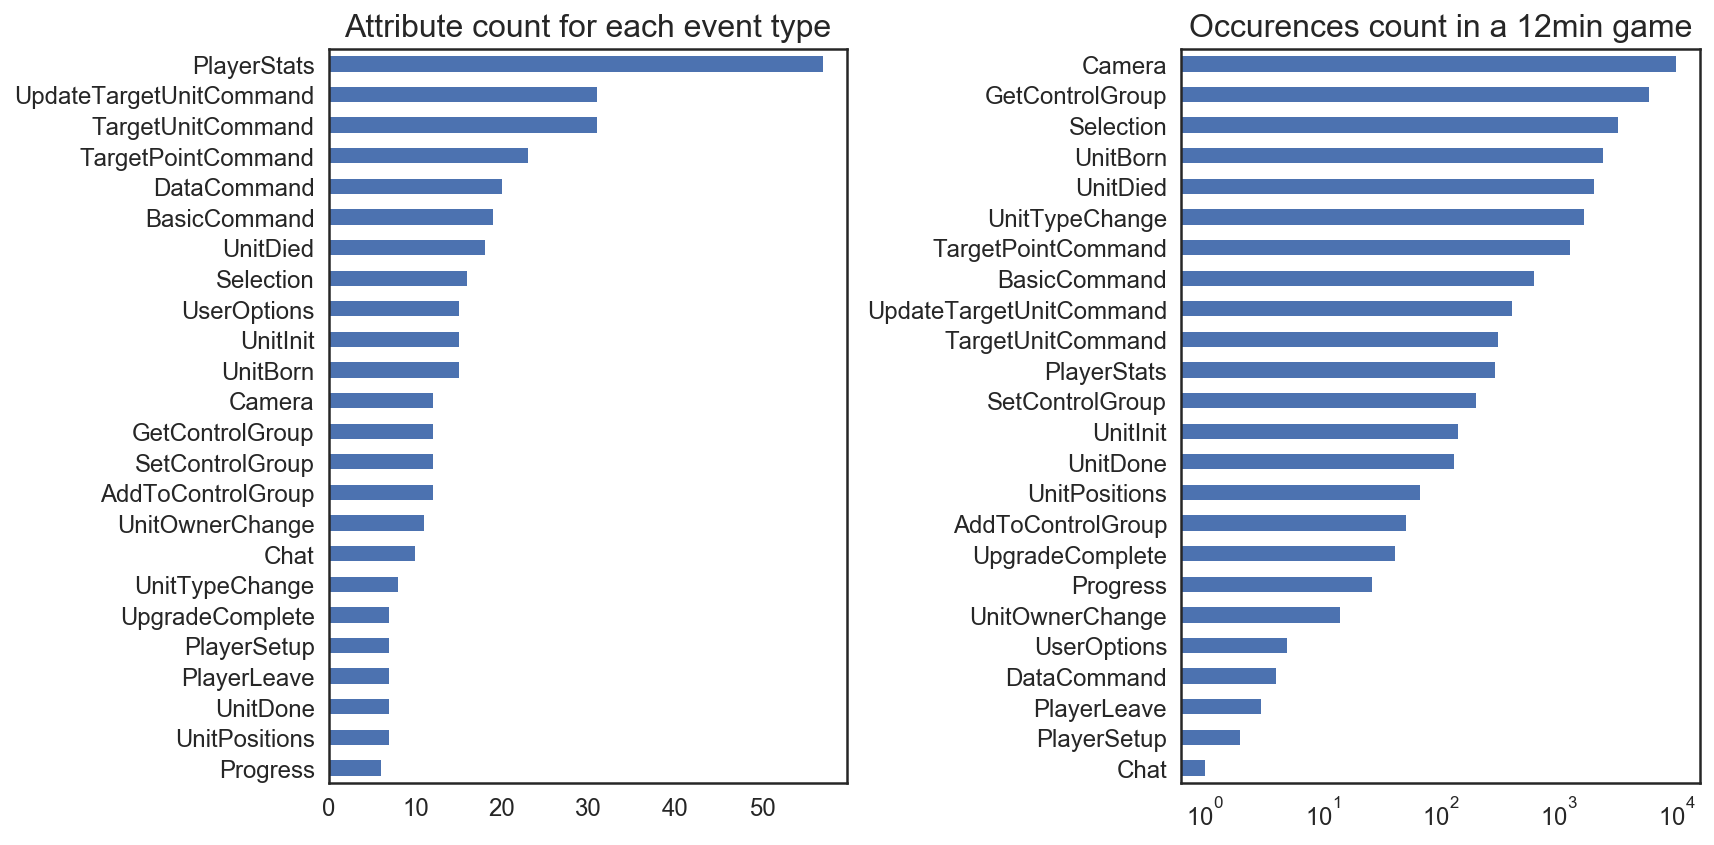

In [18]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
pd.Series({event.name[:-5]: len(list(event.__dict__.keys()))
           for event in replay.events}
         ).sort_values().plot(kind='barh', fontsize=12)
plt.title(s = 'Attribute count for each event type', size = 16)

plt.subplot(1,2,2)
event_occurence_count = pd.Series([event.name[:-5] for event in replay.events]
                                 ).value_counts(ascending = True)
event_occurence_count.plot(kind='barh', logx = True, fontsize=12)
plt.title(s = 'Occurences count in a 12min game', size = 16)

plt.tight_layout(w_pad=1, h_pad=1)
plt.show()

One natural place to start is to look at the PlayerStats events and the information it contains.

In [32]:
def getEvents(name = '', replay = replay):
    return list({event for event in replay.events if name in event.name})

plist(list(getEvents(name='PlayerStats',replay=replay)[0].__dict__.keys()), col_num=3, spacing=37)

frame                                second                               name                                 
pid                                  player                               stats                                
minerals_current                     vespene_current                      minerals_collection_rate             
vespene_collection_rate              workers_active_count                 minerals_used_in_progress_army       
minerals_used_in_progress_economy    minerals_used_in_progress_technology minerals_used_in_progress            
vespene_used_in_progress_army        vespene_used_in_progress_economy     vespene_used_in_progress_technology  
vespene_used_in_progress             resources_used_in_progress           minerals_used_current_army           
minerals_used_current_economy        minerals_used_current_technology     minerals_used_current                
vespene_used_current_army            vespene_used_current_economy         vespene_used_current_technolog

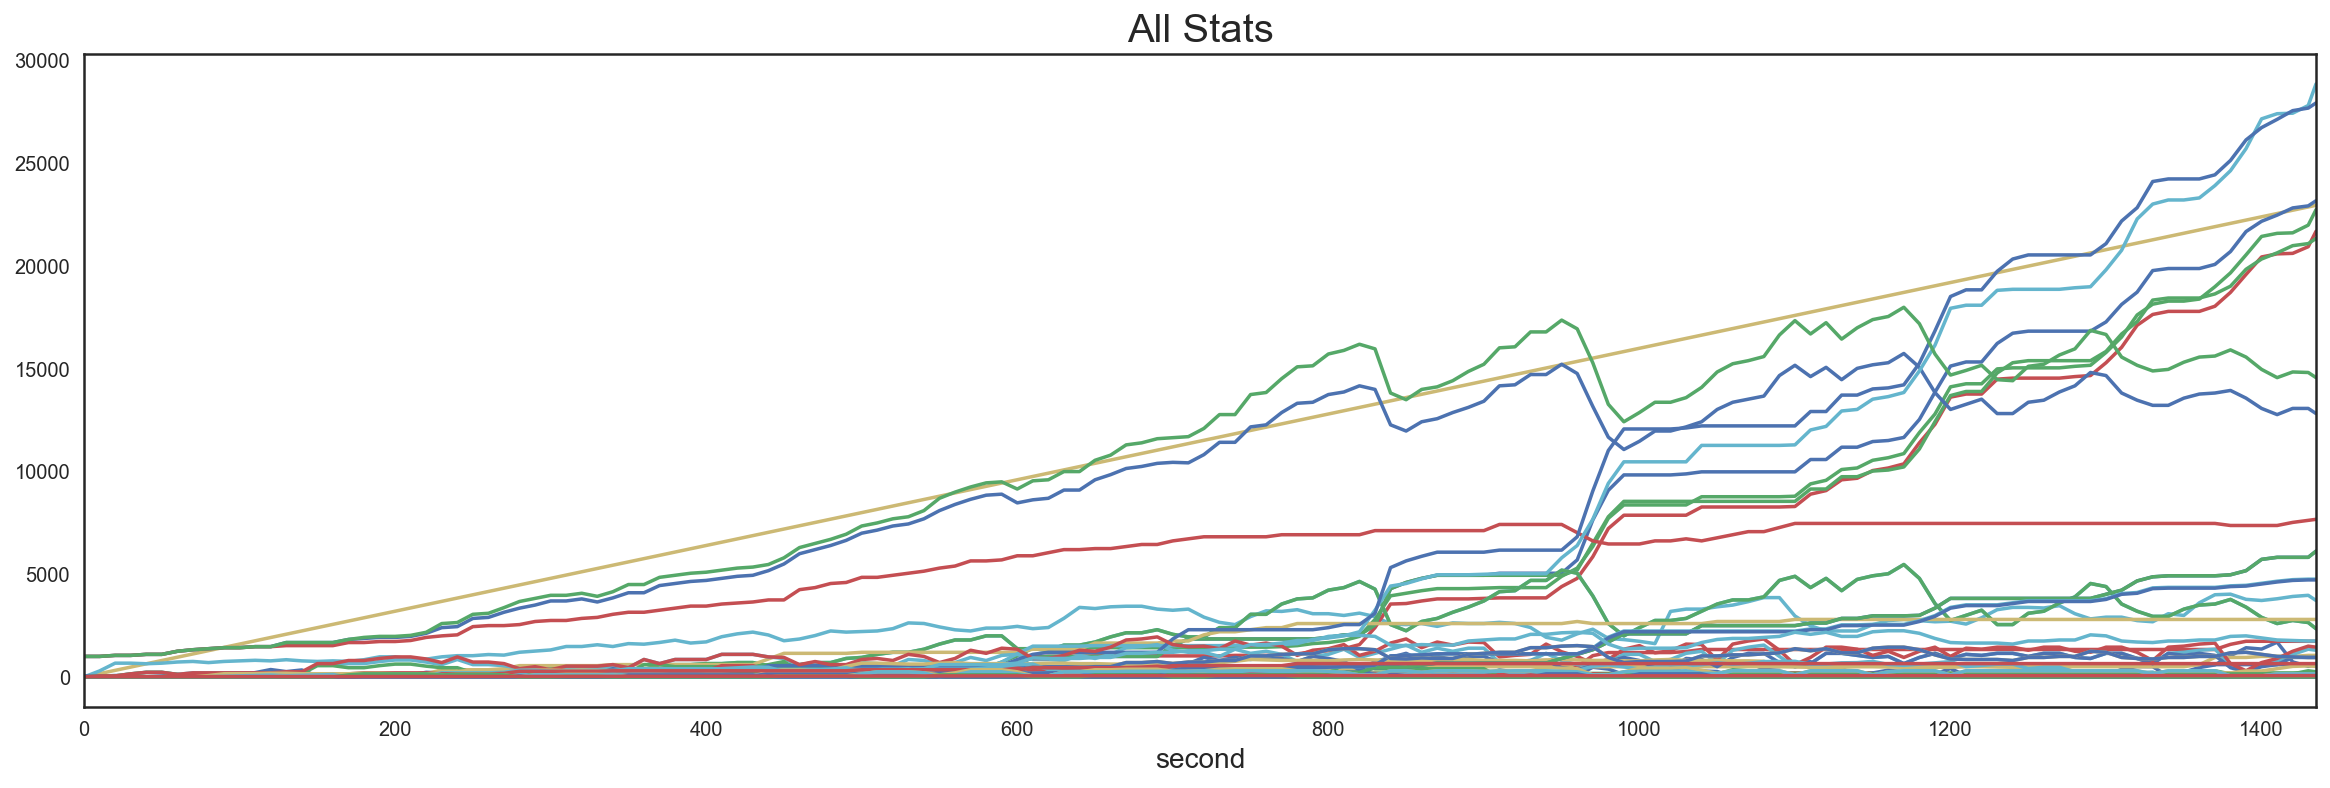

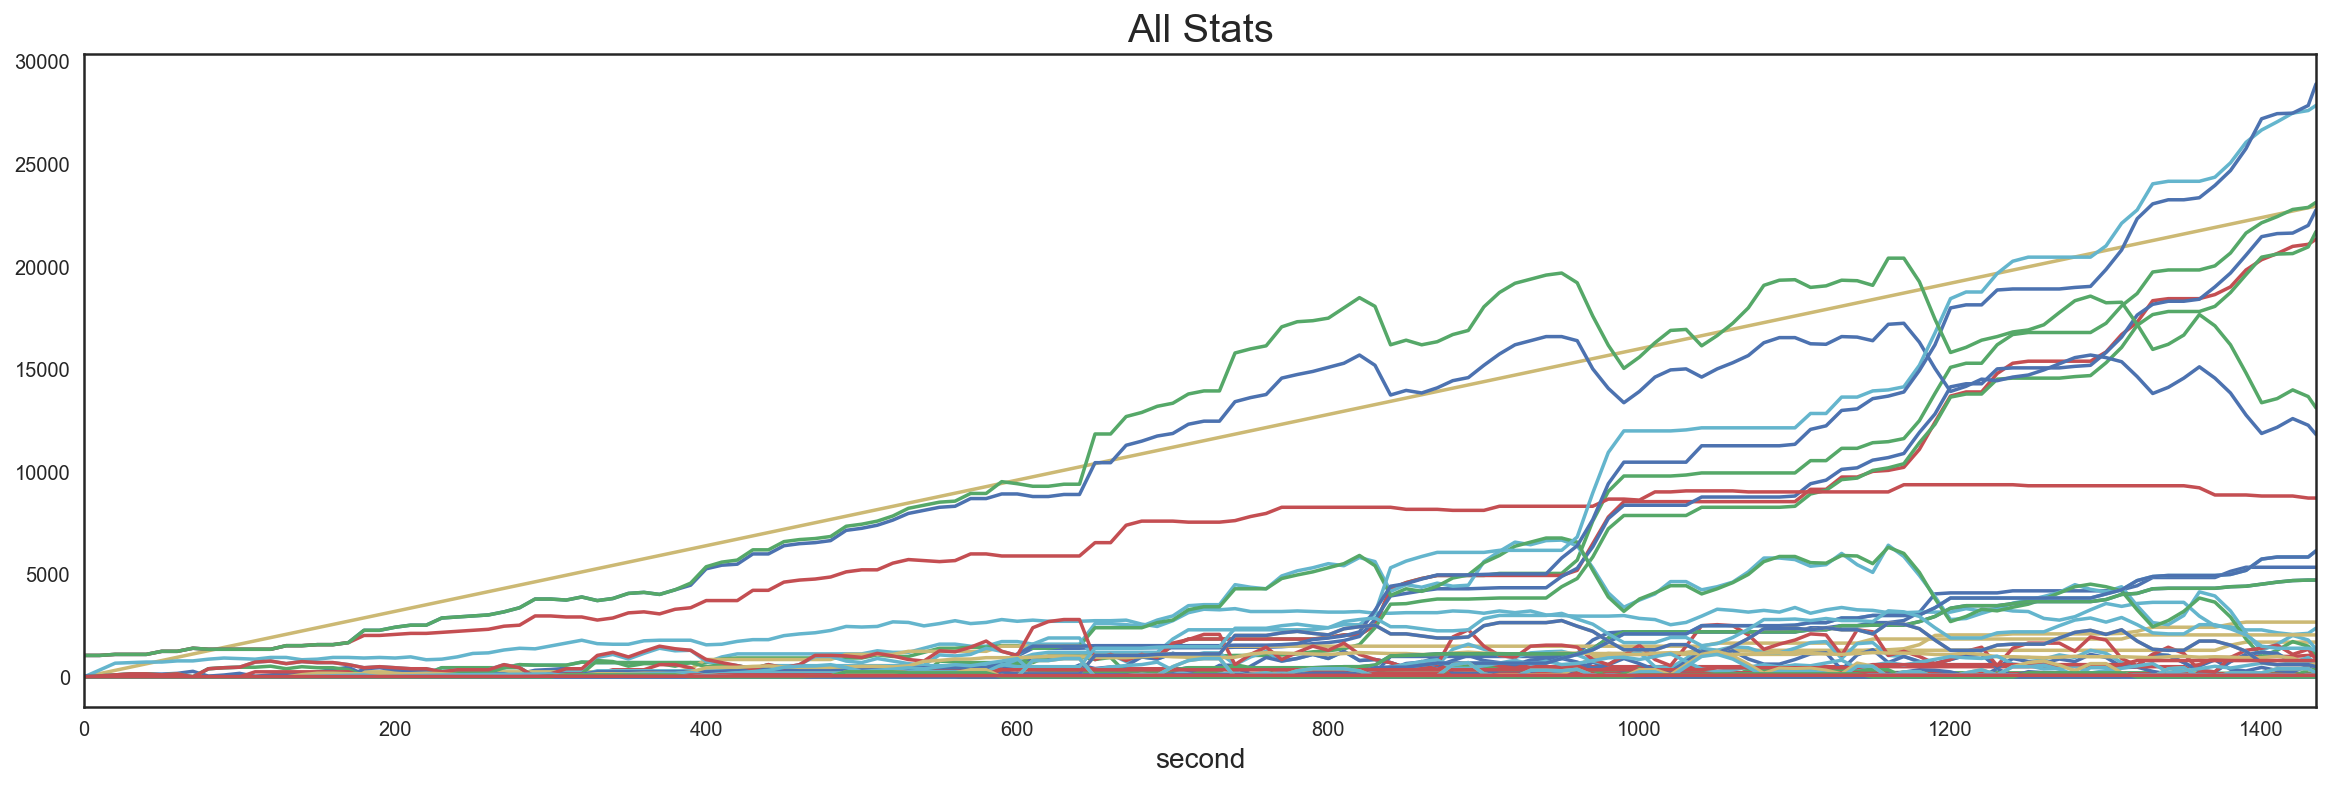

In [77]:
df = pd.DataFrame([{key:event.__dict__[key] for key in event.__dict__.keys()
              if key not in ['stats','name','player']} for event in getEvents(name='PlayerStats',replay=replay)])

df = df.sort_values(by = 'second')

_ = df.groupby('pid').plot(figsize=(20,6), x='second', legend=False, title = 'All Stats')

pid
1    Axes(0.125,0.125;0.775x0.755)
2    Axes(0.125,0.125;0.775x0.755)
dtype: object

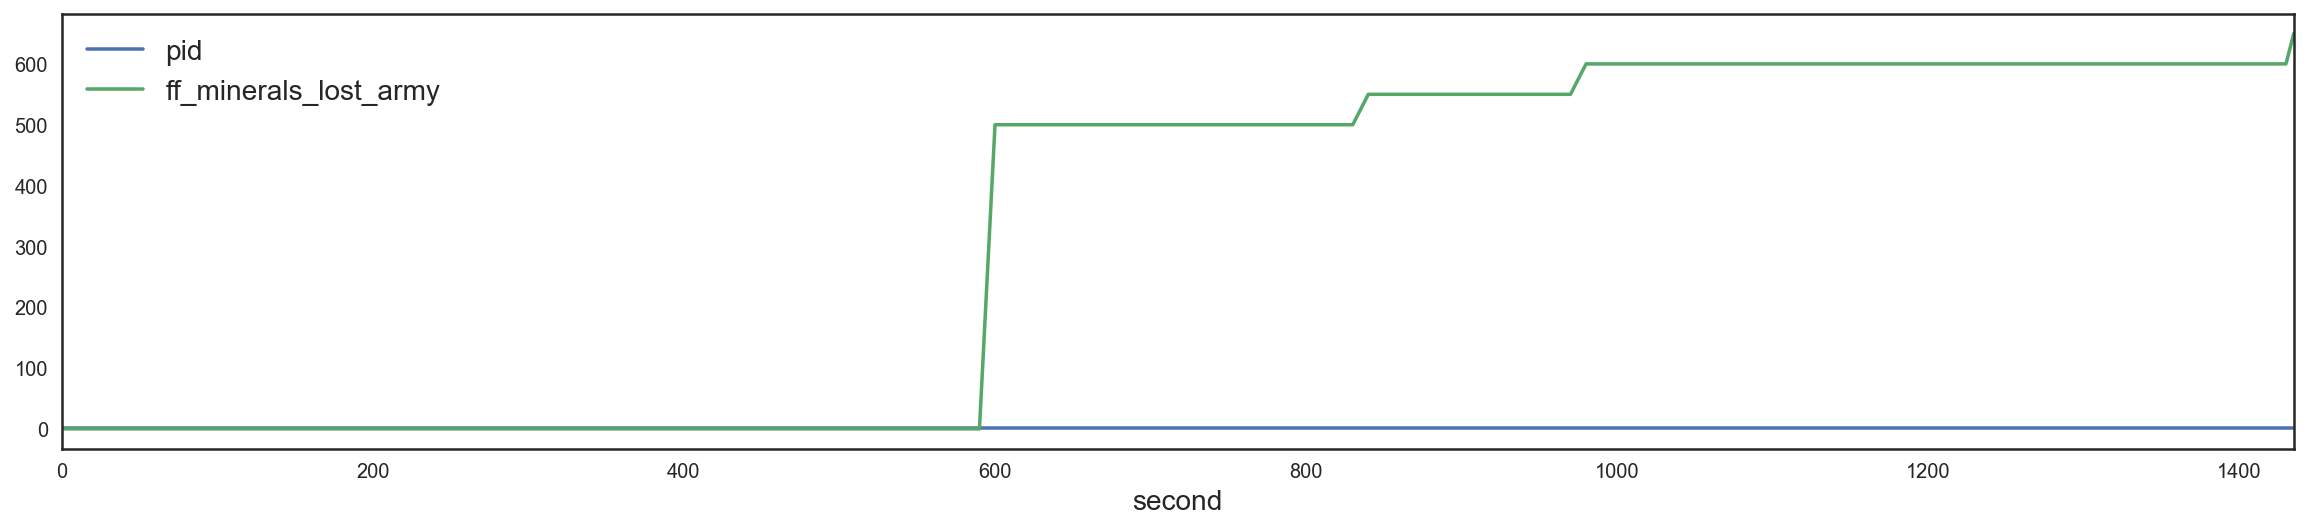

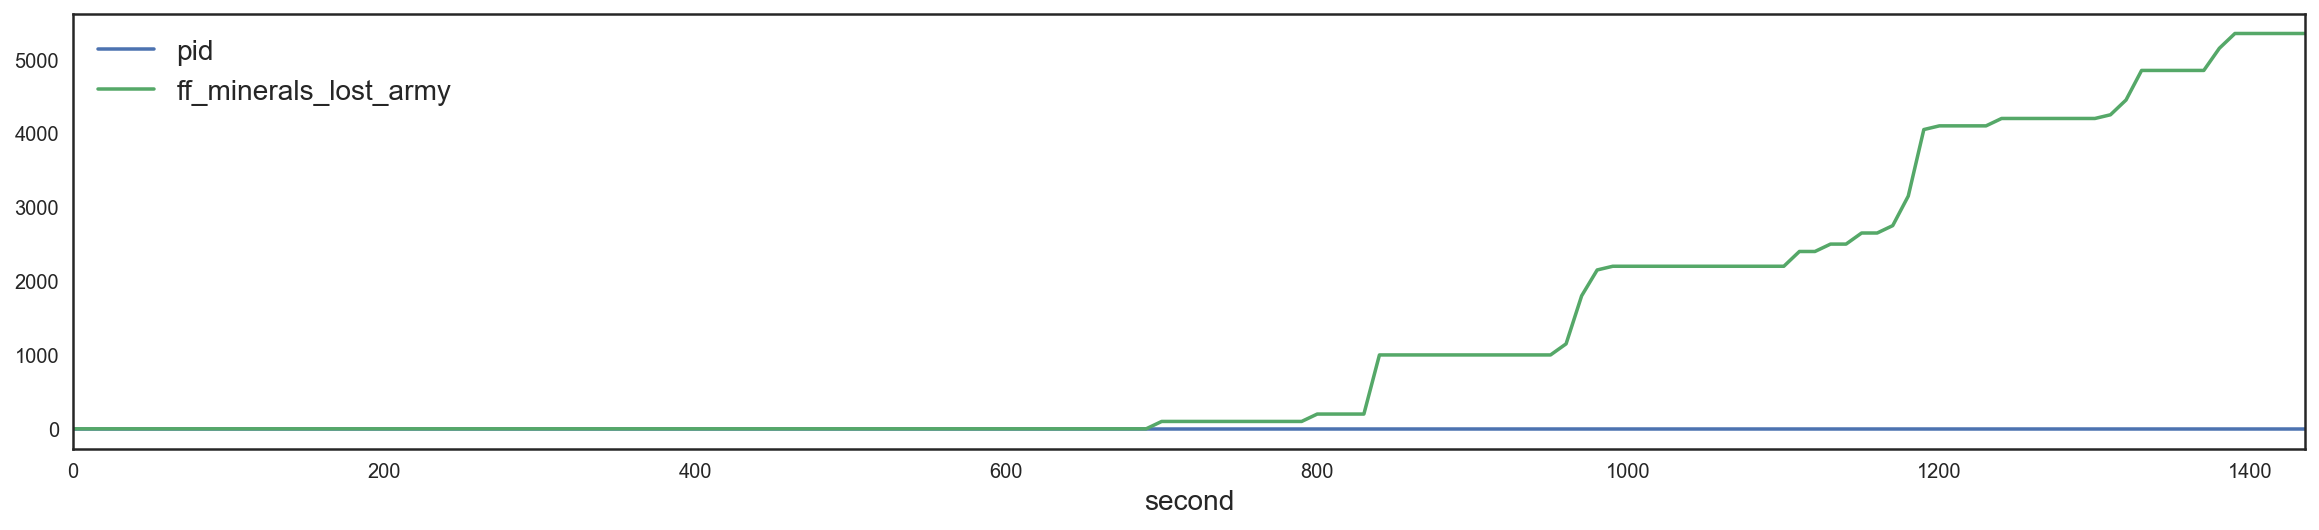

In [85]:
df[['pid','second','ff_minerals_lost_army']].groupby('pid').plot(x='second', figsize=(20,4))

For the our initial model we will not use the entirety of the data contained in the replay file. As we shall see, a somewhat detailed portrait of the game state may be obtained by looking exclusively at the unit objects.

##### A closser look at units

All starcraft 2 units, their names, images, properties, and other features can be found at this [link](http://us.battle.net/sc2/en/game/unit/).

Units in our replay file contain several attributes of interest, namely:

    name
    owner
    started_at
    finished_at
    died_at
    location
    is_army
    is_worker
    is_building
    
our desire to select units based on these features motivate the following:



In [11]:
def frames_to_irl_seconds(num): 
    return (num/16) / 1.4

def irl_seconds_to_frames(num): 
    return num * 16 * 1.4

def getUnits(units = [], time = False,
             finished_before = np.inf, finished_after = 0,
             died_before = np.inf, died_after = 0, 
             army = True, workers = True, buildings = True,
             player = None, name = None,replay = None):
    
    if type(time) != bool:
        died_after = time+1
        finished_before = time
    
    died_before = irl_seconds_to_frames(died_before)
    died_after = irl_seconds_to_frames(died_after)
    finished_before = irl_seconds_to_frames(finished_before)
    finished_after = irl_seconds_to_frames(finished_after)

    if player != None:
        units = player.units
    elif units == []:
        units = replay.players[0].units + replay.players[1].units
    else:
        units = units
        
    return [unit for unit in units 
            if (unit.finished_at != None and 
                unit.finished_at <= finished_before
                and unit.finished_at >= finished_after)
            
            and (unit.died_at == None 
                 or unit.died_at >= died_after)
    
            and (died_before == np.inf or (unit.died_at != None
                 and unit.died_at <= died_before))
            
            and ((unit.is_army and army) 
                 or (unit.is_worker and workers)
                 or (unit.is_building and buildings))
            
            and (name == None or name in unit.name)]

def getUnitFeatures(features = [], kwargs = {}):
    units = getUnits(**kwargs)
    
    attributes = [feature for feature in features if feature not in ['player','unit']]
    df = pd.DataFrame({feature: [unit.__getattribute__(feature) for unit in units] for feature in attributes}, 
                      columns=features)
    
    df.applymap(lambda x:np.nan if x == None else x)
    
    for col in list(set(df.columns) & set(['started_at','died_at', 'finished_at'])):
        df[col] = df[col].apply(frames_to_irl_seconds).apply(lambda x:int(x) 
                                                             if np.isnan(x) == False 
                                                             else np.complex('j'))
    
    special_features = [feature for feature in features if feature in ['player','unit']]
    if 'player' in special_features:
        df['player'] = [unit.owner.pid for unit in units]
    
    if 'unit' in special_features:
        df['unit'] = units
    return df

Exampe usage:

In [12]:
getUnits(name='Hellion', replay = replay)

[Hellion [4180003],
 Hellion [3F00007],
 Hellion [4940001],
 Hellion [3B40004],
 Hellion [5040003],
 Hellion [50C0002]]

In [13]:
getUnitFeatures(['name','location','minerals','vespene','finished_at','died_at','is_army','player','unit'], 
                kwargs={'replay':replay, 'name':'Hellion'})

,name,location,minerals,vespene,finished_at,died_at,is_army,player,unit
0,Hellion,"(28, 126)",100,0,186,232,True,1,Hellion [4180003]
1,Hellion,"(29, 127)",100,0,186,233,True,1,Hellion [3F00007]
2,Hellion,"(80, 121)",100,0,210,429,True,1,Hellion [4940001]
3,Hellion,"(73, 126)",100,0,212,427,True,1,Hellion [3B40004]
4,Hellion,"(79, 123)",100,0,257,428,True,1,Hellion [5040003]
5,Hellion,"(79, 124)",100,0,257,429,True,1,Hellion [50C0002]


In [14]:
getUnitFeatures(['name','location','minerals','vespene','finished_at','died_at','is_army','player','unit'], 
                kwargs={'replay':replay, 'name':'Mutalisk'}).head()

,name,location,minerals,vespene,finished_at,died_at,is_army,player,unit
0,Mutalisk,"(149, 79)",100,100,458,740,True,2,Mutalisk [7340004]
1,Mutalisk,"(113, 32)",100,100,458,558,True,2,Mutalisk [5F80008]
2,Mutalisk,"(99, 67)",100,100,459,857,True,2,Mutalisk [6080003]
3,Mutalisk,"(148, 77)",100,100,459,739,True,2,Mutalisk [7B00002]
4,Mutalisk,"(84, 102)",100,100,459,996,True,2,Mutalisk [7DC0001]


In [15]:
def mineralValue(units):
    return sum(unit.minerals for unit in units)

def gasValue(units):
    return sum(unit.vespene for unit in units)

AttributeError: module 'matplotlib.pyplot' has no attribute 'tight_layou'

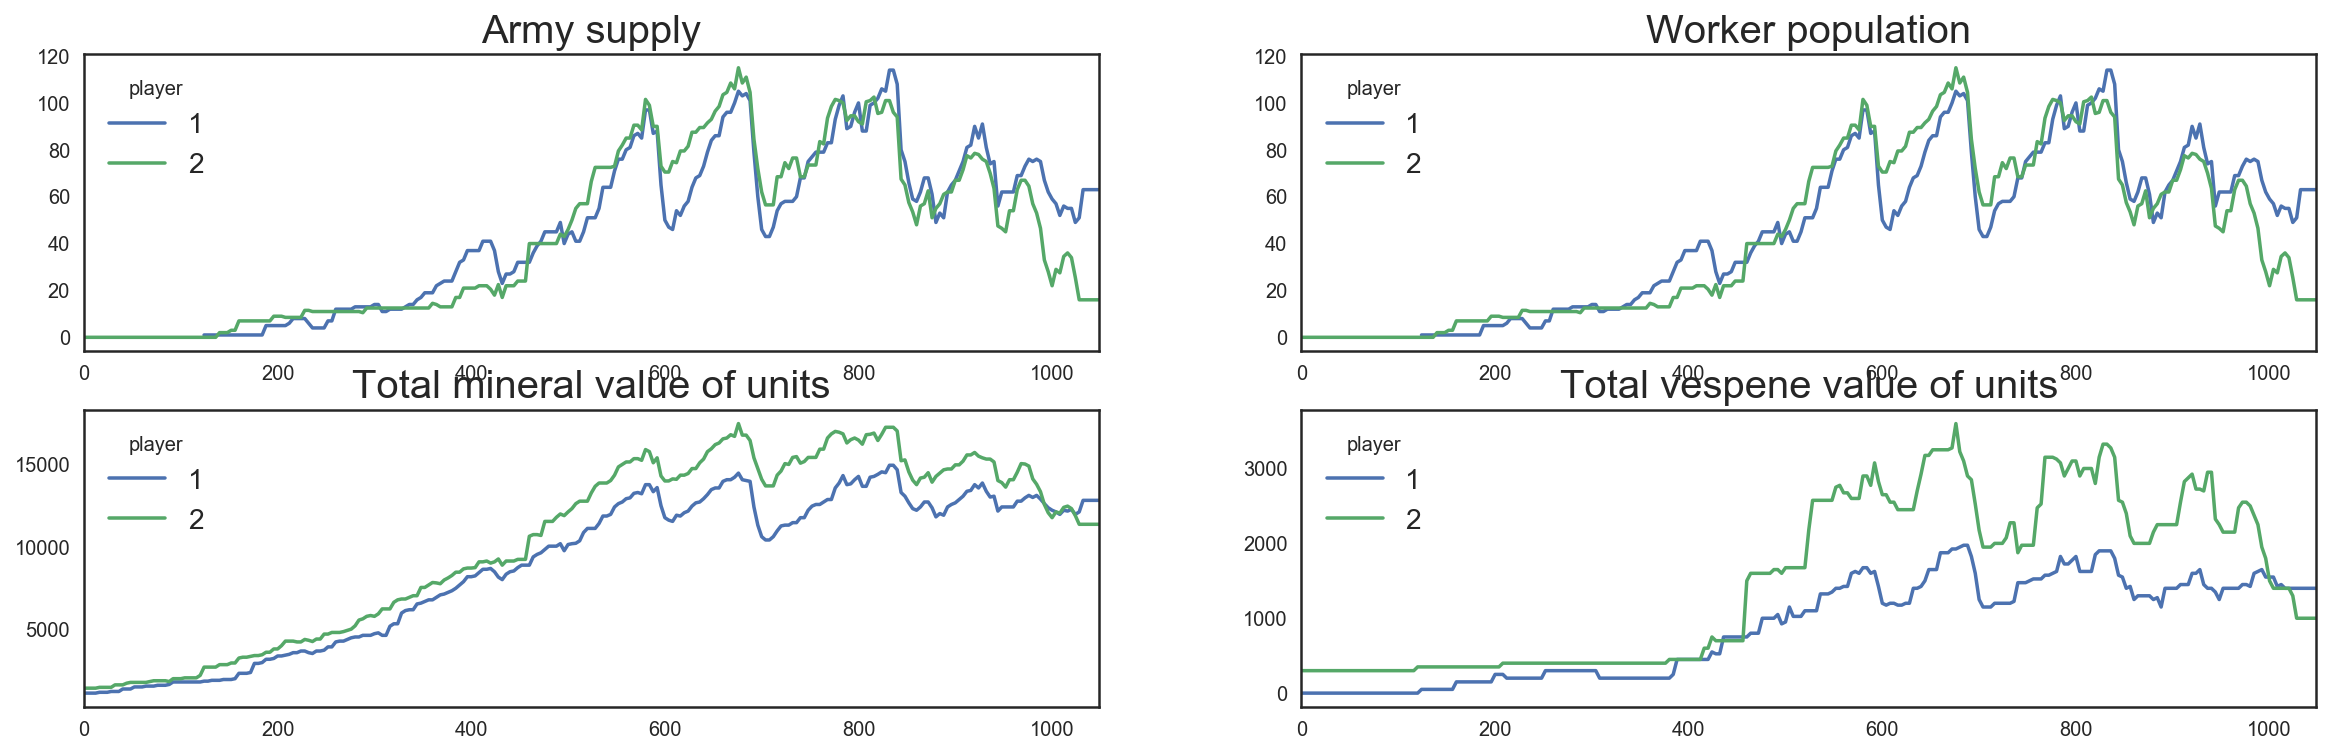

In [16]:
units_df_over_time = pd.Series(
    {t:getUnitFeatures(['supply','is_army','is_worker','minerals','vespene','player'],kwargs={'replay':replay, 'time':t}
                            ) for t in range(0,17*60 + 30,4)})

army_supply = units_df_over_time.apply(lambda x:x[x['is_army'] == True].groupby('player')['supply'].sum())
worker_supply = units_df_over_time.apply(lambda x:x[x['is_worker'] == True].groupby('player')['supply'].sum())

mineral_value = units_df_over_time.apply(lambda x:x.groupby('player')['minerals'].sum())
vespene_value = units_df_over_time.apply(lambda x:x.groupby('player')['vespene'].sum())

fig, axes = plt.subplots(nrows=2, ncols=2)

army_supply.plot(ax=axes[0,0], figsize=(20,6), title='Army supply')
army_supply.plot(ax=axes[0,1], figsize=(20,6), title='Worker population')
mineral_value.plot(ax=axes[1,0], figsize=(20,6), title = 'Total mineral value of units')
vespene_value.plot(ax=axes[1,1], figsize=(20,6), title = 'Total vespene value of units')

plt.tight_layou
plt.show()


In [ ]:
replay.players

In [ ]:
plt.figure(figsize=(16,10))
plt.suptitle('Visualizing some aspects of the game', fontsize=18)

# Plotting basic miliratry units
plt.subplot(2,2,1)
pd.Series({t:getUnitFeatures(
    ['name'],kwargs={'replay':replay, 'name':'Marine', 'time':t}
                            ).shape[0] for t in range(0,12*60 + 30)}).plot()

pd.Series({t:getUnitFeatures(
    ['name'],kwargs={'replay':replay, 'name':'Zergling', 'time':t}
                            ).shape[0] for t in range(0,12*60 + 30)}).plot()

plt.title('Basic army unit counts\n(Marine / Zergling)', fontsize=18)

plt.legend(['player1', 'player2'], bbox_to_anchor=(0., 1.02, 1., .102),loc=3,ncol=2,
                   mode="expand", borderaxespad=0.)
# Plotting basic economic units
plt.subplot(2,2,2)
pd.Series({t:getUnitFeatures(
    ['name'],kwargs={'replay':replay, 'name':'SCV', 'time':t}
                            ).shape[0] for t in range(0,12*60 + 30)}).plot()

pd.Series({t:getUnitFeatures(
    ['name'],kwargs={'replay':replay, 'name':'Drone', 'time':t}
                            ).shape[0] for t in range(0,12*60 + 30)}).plot(label = 'Drones')

plt.title('Non army units counts\n(SCV / Drone)', fontsize=18)
plt.legend(['player1', 'player2'], bbox_to_anchor=(0., 1.02, 1., .102),loc=3,ncol=2,
                   mode="expand", borderaxespad=0.)
# Plotting total army/economy mineral value
plt.subplot(2,2,3)
pd.Series({t:mineralValue(getUnitFeatures(features=['unit'],kwargs={'player':replay.players[0],'time':t}
                            )['unit']) for t in range(0,12*60 + 30)}).plot()

pd.Series({t:mineralValue(getUnitFeatures(features=['unit'],kwargs={'player':replay.players[1],'time':t}
                            )['unit']) for t in range(0,12*60 + 30)}).plot()

plt.xlabel('seconds', fontsize=12)
plt.title('Total mineral value of all units', fontsize=18)
plt.legend(['player1', 'player2'], bbox_to_anchor=(0., 1.02, 1., .102),loc=3,ncol=2,
                   mode="expand", borderaxespad=0.)
# Plotting total army/economy vespene gas value
plt.subplot(2,2,4)
pd.Series({t:gasValue(getUnitFeatures(features=['unit'],kwargs={'player':replay.players[0],'time':t}
                            )['unit']) for t in range(0,12*60 + 30)}).plot()

pd.Series({t:gasValue(getUnitFeatures(features=['unit'],kwargs={'player':replay.players[1],'time':t}
                            )['unit']) for t in range(0,12*60 + 30)}).plot()

plt.xlabel('seconds', fontsize=12)
plt.title('Total gas value of all units', fontsize=18)
plt.legend(['player1', 'player2'], bbox_to_anchor=(0., 1.02, 1., .102),loc=3,ncol=2,
                   mode="expand", borderaxespad=0.)


plt.tight_layout = True
plt.show()

##### Using unit information to visualize the game state
Plotting of game

In [ ]:
def getXY(iterable):
    return [[obj[0] for obj in iterable],[obj[1] for obj in iterable]]

def getLocations(units):
    return [unit.location for unit in units]

def getUnitType(units = [], name = ''):
    return [unit for unit in units if name in unit.name]

def plotGameState(replay = None,
                 time = 0,
                 minerals = True,
                 vespene = True,
                 towers = True,
                 workers = True,
                 army = True,
                 buildings = True,
                 ramps = True,
                 kwargs = {}):
    
    kwargs['time'] = time
    
    all_units = list(replay.active_units.values())
    p1 = replay.players[0]
    p2 = replay.players[1]
    
    terran_colors = ['#0703d4','#e31a00']
    zerg_colors   = ['#a01cd9','#e00283']
    protos_colors = ['e6cf00', '#e89b00']

    classic_colors = {'Terran':terran_colors, 
                      'Zerg':zerg_colors, 
                      'Protoss':protos_colors}

    p1c = classic_colors[replay.players[0].play_race][0]
    p2c = classic_colors[replay.players[1].play_race][1]

        
    if minerals:
        mineralfields = getXY(getLocations(getUnitType(all_units, name = 'MineralField')))
        plt.scatter(mineralfields[0], mineralfields[1], color = '#44a7f2', alpha=1)
    
    if vespene:
        vespenegeyser = getXY(getLocations(getUnitType(all_units, name = 'VespeneGeyser')))
        plt.scatter(vespenegeyser[0], vespenegeyser[1], color = '#3ed121', alpha=1)
        
    if towers:  
        xelnagatowers = getXY(getLocations(getUnitType(all_units, name = 'XelNagaTower')))
        plt.scatter(xelnagatowers[0], xelnagatowers[1], color = 'k', alpha=0.5)
        
    if ramps:
        destructibleramp = getXY(getLocations(getUnitType(all_units, name = 'Destructible')))
        plt.scatter(destructibleramp[0], destructibleramp[1], color = 'orange', alpha=0.5, s = 100, marker='s')
        
    if workers:
        p1workers = getXY(getLocations(getUnits(player=p1,workers=True, army = False, buildings = False, **kwargs)))
        p2workers = getXY(getLocations(getUnits(player=p2,workers=True, army = False, buildings = False, **kwargs)))

        plt.scatter(p1workers[0], p1workers[1], color = p1c, s = 10)
        plt.scatter(p2workers[0], p2workers[1], color = p2c, s = 10)
        
    if army:
        p1army = getXY(getLocations(getUnits(player=p1,workers=False, army = True, buildings = False, **kwargs)))
        p2army = getXY(getLocations(getUnits(player=p2,workers=False, army = True, buildings = False, **kwargs)))

        plt.scatter(p1army[0], p1army[1], color = p1c, s = 10, marker='*', alpha=0.5)
        plt.scatter(p2army[0], p2army[1], color = p2c, s = 10, marker='*', alpha=0.5)
        
    if buildings:
        p1buildings = getXY(getLocations(getUnits(player=p1,workers=False, army = False, buildings = True, **kwargs)))
        p2buildings = getXY(getLocations(getUnits(player=p2,workers=False, army = False, buildings = True, **kwargs)))

        plt.scatter(p1buildings[0], p1buildings[1], c = p1c, s = 100, marker='s', alpha=0.5)
        plt.scatter(p2buildings[0], p2buildings[1], c = p2c, s = 100, marker='s', alpha=0.5)
        
    minx = min(mineralfields[0]) - 20
    maxx = max(mineralfields[0]) + 20
    miny = min(mineralfields[1]) - 20
    maxy = max(mineralfields[1]) + 20
    plt.xlim([minx,maxx])
    plt.ylim([miny,maxy])

    plt.title('Map: ' + current_game.map_name + '\n'
              + 'Players: ' + current_game.players[0].name + ' / ' + current_game.players[1].name)
    plt.show()

def plwrap(time = 0, **kwargs):
    plotGameState(time=time, replay=current_game, **kwargs)
    return None

def plot_replay_of_current_game():
    current_game = replay

    interact(plwrap, time=IntSlider(min=0, max=frames_to_irl_seconds(replay.frames), step=4))
    return None

In [ ]:
current_game = replay
plot_replay_of_current_game()

---

---

### Acquiring initial data

<a id = 'Tabulating the data'></a>
### Tabulating the data
The replay game file as a whole is not - in its original form - tracktable by the medhods we seek to apply.

Our goal is to build a function 

    f(Game State at T) = P(player concedes at t > T | GameState at T)

Which informs the form we must impose on the data.

Since we need the game state at time T for each individual value of T we wish to querry we will split a single game file across many records in our table. We choose (heuristicaly) a 1min sampling frequency.
 
At this stage is is not yet clear what features we will need to include, but we deem it certain that a tally of the units each player has on the board will be essential in developing our model.

In [ ]:
def getCoreState(t, replay):
    df = getUnitFeatures(features=['name','race','player'],
                         kwargs={'time':t, 'replay':replay}).apply(lambda x: 
                                                                   str(x['player'])
                                                                   +x['race'][0]
                                                                   +'_'
                                                                   +x['name'], 
                                                  axis = 1).value_counts()
    return df

def game_to_dataframe(replay, sample_interval = 30):
    df = pd.DataFrame(data = [getCoreState(t,replay) for t in range(0,int(frames_to_irl_seconds(replay.frames)),sample_interval)]).fillna(0)
    df['time'] = range(0,int(frames_to_irl_seconds(replay.frames)),sample_interval)
    df['time_to_end'] = int(frames_to_irl_seconds(replay.frames)) - df['time']
    df['winner'] = replay.winner.number
    df['game_id'] = replay.filename
    return df

example_df = game_to_dataframe(replay, sample_interval=60)
example_df

In [ ]:
example_df = game_to_dataframe(replay, sample_interval=60)
plt.figure(figsize=(10,10))
sns.heatmap(example_df.iloc[:,:-4].T.corr(),cbar=False)

In [ ]:
cell_width(100)

In [ ]:
i = 0
plt.figure(figsize=(20,20))
for replayi in games_IEM[0:25]:
    i+=1
    plt.subplot(5,5,i)
    example_dfi = game_to_dataframe(replayi, sample_interval=60)
    sns.heatmap(example_dfi.iloc[:,:-4].T.corr(),cbar=False)
plt.show()

In [ ]:
current_game = games_IEM[16]
plot_replay_of_current_game()

In [ ]:
example_dfi.iloc[:,:-4].T.corr().describe()

## Preliminary modeling

In [ ]:
def getXy(df, 
          more_than_t_min_to_end = 0, 
          less_than_t_min_to_end = 999, 
          minute = None,
          target = 'winner'):
    
    if minute == None:
        df_p = df[df['time_to_end'] >= more_than_t_min_to_end*60]
        df_p = df_p[df_p['time_to_end'] <= less_than_t_min_to_end*60]
    else: 
        df_p = df[df['time'] == minute*60]
        
    X = df_p[[col for col in df_p.columns if col not in ['winner','game_id','time_to_end','time', '1_map_coverage','2_map_coverage','Unnamed: 0']]]
    y = df_p[target]
    
    return (X,y)

df_of_games = pd.read_csv('./IME_2017_bag_of_units.csv')    
X,y = getXy(dfgv)
Xtr,Xte,ytr, yte = train_test_split(X,y, test_size = 0.2, 
                                    random_state = 2)


In [ ]:
len(unit_names)

In [ ]:
dfgv = df_of_games[[col for col in df_of_games.columns if any([name in col for name in unit_names])]]

In [ ]:
# Baseline
max(1-(yte-1).mean(),(yte-1).mean()) 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

lr = LogisticRegression()
lr.fit(Xtr,ytr).score(Xte,yte)

In [ ]:
plt.figure(figsize = (25,15))
sns.heatmap(X.corr(), linewidths=0.01, cbar=False, yticklabels=False)
plt.xticks(size=8)
plt.show()

In [ ]:
plt.figure(figsize = (6,6))
sns.heatmap(X[[col for col in X.columns if col[0:2]=='1T']].corr(), linewidths=0.01, cbar=False)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

In [ ]:
plist(Xtr.columns , spacing=30)

In [ ]:
rfc = RandomForestClassifier(n_estimators=800)
rfc.fit(Xtr, ytr).score(Xte,yte)

In [ ]:
X,y = getXy(df_of_games, more_than_t_min_to_end=5, less_than_t_min_to_end=8)
Xtr,Xte,ytr, yte = train_test_split(X,y, test_size = 0.2, 
                                    random_state = 2)

rfc.fit(Xtr, ytr).score(Xte,yte)

In [ ]:
X,y = getXy(df_of_games, more_than_t_min_to_end=10, less_than_t_min_to_end=999)
Xtr,Xte,ytr, yte = train_test_split(X,y, test_size = 0.2, 
                                    random_state = 2)

rfc.fit(Xtr, ytr).score(Xte,yte)

In [ ]:
X,y = getXy(df_of_games, more_than_t_min_to_end=15, less_than_t_min_to_end=999)
Xtr,Xte,ytr, yte = train_test_split(X,y, test_size = 0.2, 
                                    random_state = 2)

rfc.fit(Xtr, ytr).score(Xte,yte)

In [ ]:
params_rfc = {'n_estimators':[100], 
  'criterion':['entropy','gini'],
  'max_depth':[None], 
  'min_samples_split':[2], 
  'min_samples_leaf':[1], 
  'min_weight_fraction_leaf':[0.0], 
  'max_features':['auto','sqrt','log2',None,0.25,0.5,0.75], 
  'max_leaf_nodes':[None], 
  'min_impurity_split':[1e-07], 
  'bootstrap':[True], 
  'oob_score':[False], 
  'n_jobs':[1], 
  'random_state':[None], 
  'verbose':[0], 
  'warm_start':[False]}
              
gs = GridSearchCV(rfc, param_grid=params_rfc, verbose=0)

In [ ]:
gs.fit(Xtr,ytr)
gs.best_score_

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=200)

y_t = df_of_games['time_to_end']
X_t = df_of_games.drop(['time_to_end', 'game_id','time'], axis=1)
Xtr,Xte,ytr, yte = train_test_split(X_t,y_t, test_size = 0.2, 
                                    random_state = 2)

rfr.fit(Xtr, ytr).score(Xte,yte)

In [ ]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(Xtr,ytr).score(Xte,yte)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(yte, lm.predict(Xte))

In [ ]:
mean_squared_error(yte, rfr.predict(Xte))

In [ ]:
from sklearn.learning_curve import learning_curve

le

### Feature segregation

Due to the irreducible quantity of information that is inherent to every starcraft match, we segregate the information in each game into the following groups:

- Innitial conditions, actions, choices or outcomes that could only be known by the players post-facto.
        eg. player_1 sends a SCV to (x,y) = (17,5) at t = 6s
- Innitial game conditions that are known to all parties as the game begins.
        eg. game_map == "Abysal Rift"
- Contextual information that are know to all parties as the game begins but that is not inherent to the game in any way.
        eg. the ranking of player_1 at the time of the game.

### The toolkit

The techniques at hand are:

    LinearRegression
    LogisticRegression
    Lasso
    Ridge
    SGDClassifier
    SGDRegressor
    SVC
    SVR
    DecisionTreeClassifier 
    DecisionTreeRegressor
    BaggingClassifier
    BaggingRegressor
    RandomForestClassifier
    RandomForestRegressor

In [ ]:
def replay_to_df(replay):
    dictionary = {'type':replay.type,
                  'category':replay.category,
                  'competitive':replay.competitive,
                  'game_version': replay.expansion,
                  'game_start_time':replay.start_time,
                  'game_end_time':replay.end_time,
                  'is_ladder': replay.is_ladder,
                  'map':replay.map_name,
                  'region':replay.region,
                  'relese_version':replay.release_string,
                  'speed':replay.speed,
                  'time_zone': replay.time_zone,
                  'player1_name':replay.player[1].name,
                  'player2_name':replay.player[2].name,
                  'player1_race':replay.player[1].play_race,
                  'player2_race':replay.player[2].play_race,
                  'player1_result':replay.player[1].result,
                  'player2_result':replay.player[2].result}
    return dictionary
            
    
    def getState(t, player = None):
        df = getUnitFeatures(features=['name','finished_at','location','minerals','vespene','started_at', 'is_army', 'is_worker', 'is_building'], 
                        special_features=[], 
                        kwargs={'player':player, 'time':t, 'army':True})

        df['x'] = df['location'].apply(lambda x:x[0])
        df['y'] = df['location'].apply(lambda x:x[1])

        df.drop(['location'], axis=1, inplace=True)

        df_a = df.pivot_table(columns='name', values=['x','y'], aggfunc = 'mean')
        df_b = df.pivot_table(columns='name', values=['minerals','vespene','is_army','is_worker','is_building'], aggfunc = 'sum')
        df_c = pd.concat([df_a,df_b])
        df_minerals = df_c.loc[['minerals']]
        df_minerals.columns = [col + '_minerals' for col in df_minerals.columns]
        df_vespene = df_c.loc[['vespene']]
        df_vespene.columns = [col + '_vespene' for col in df_vespene.columns]
        df_minerals.index = [t]
        df_vespene.index = [t]
        return pd.concat([df_minerals, df_vespene], axis=1)

                  


We will also try to capture the intuition of each player by performing liberal feature engeneering. Those familiar with the Starcraft profecional scene will have harbour no doubt that players such as Inovation and HerO could tell you their mineral colection rate or their total resources spent on upgrades at a moment's notice.

In [ ]:
b_url = 'http://lotv.spawningtool.com/zip/?pro_only=on&p='
for i in range(60,80):
    url = b_url + str(i)
    #requests.get(url)
    print(url)

In [ ]:
games_lol = []
for i in range(0,521):
    game_file = '/Volumes/ESSD/Download_Redirect/Downloads_1_21_of_All_games/replay-{}.SC2Replay'.format(str(i))
    try:
        games_lol.append(sc2reader.load_replay(game_file))
    except:
        print(i,end=';')

In [ ]:
len([i for i in range(0,521) if i not in numbers_that_fail])

In [ ]:
games_df_lol = []
for game in games_lol:
    try:
        games_df_lol.append(game_to_dataframe(game))
    except:
        print('ups')

In [ ]:
df_of_games_lol = pd.concat(games_df_lol).fillna(0)

In [ ]:
X.shape

In [ ]:
a.shape

In [ ]:
X,y = getXy(df_of_games)

In [ ]:
X.shape

In [ ]:
X.head()

In [ ]:
joint = pd.concat([df_of_games,df_of_games_lol]).fillna(0)

In [ ]:
X_a = joint.iloc[0:7880,:]

In [ ]:
a_end = joint.iloc[7880:,:]

In [ ]:
1-(ytest-1).mean()

In [ ]:
scores = []
for i in range(0,30):
    Xe,ye = getXy(joint, minute=i)
    score = cross_val_score(rfc, Xe,ye,cv=5, n_jobs=2)
    scores.append(score)

In [ ]:
1+2

In [ ]:
df_comunity = pd.read_csv('./comunity_games.csv')
df_IME = pd.read_csv('./IME_2017_bag_of_units.csv')

In [ ]:
X,y = getXy(pd.concat([df,df_IME]).fillna(0), minute=3)

In [ ]:
X.shape

In [ ]:
pro_games_df = []
for game in games_lol:
    try:
        pro_games_df.append(game_to_dataframe(game))
    except:
        print('ups')

In [ ]:
pro_games = []
nums_that_fail = []
nums_that_work = []
for i in range(0,521):
    game_file = '/Volumes/ESSD/ProSC2games/Games/pro_replay{}.SC2Replay'.format(str(i))
    try:
        pro_games.append(sc2reader.load_replay(game_file))
        nums_that_work.append(i)
    except:
        print(i,end=';')
        nums_that_fail.append(i)

In [ ]:
len(pro_games)

In [ ]:
print(nums_that_fail)

In [ ]:
pro_games_df = []
for game in pro_games:
    try:
        pro_games_df.append(game_to_dataframe(game))
    except:
        print('ups')

In [ ]:
df_pro = pd.concat(pro_games_df).fillna(0)

In [ ]:
df_pro

In [ ]:
df_IME.shape

In [ ]:
df.shape

In [ ]:
X.shape

In [ ]:
X.drop_duplicates().shape

In [ ]:
X,y = getXy(, more_than_t_min_to_end=1, less_than_t_min_to_end=1.5)

Xtr,Xte,ytr,yte = train_test_split(X,y, test_size = 0.3)

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=800)
rfc.fit(Xtr,ytr).score(Xte,yte)

In [ ]:
plist(X.columns, spacing=30)

In [ ]:
%run ./../../../mk_models.py

In [ ]:
X.he

In [ ]:
all_games = pd.concat([df_comunity,df_IME,df_pro]).fillna(0).drop(['Unnamed: 0'], axis=1)

In [ ]:
X,y = getXy(all_games,minute=0,target='time_to_end')

In [ ]:
lm = LinearRegression()
cross_val_score(lm,X,y,cv=5).mean()

In [ ]:
r2 = []
for i in range(0,30):
    X,y = getXy(all_games,minute=i,target='time_to_end')
    r2.append(cross_val_score(rfr,X,y,cv=5).mean())

In [ ]:
plt.plot(list(range(0,30)),r2)
plt.show()

In [ ]:
scores = []
for i in range(0,30):
    X,y = getXy(all_games,minute=i)
    scores.append(cross_val_score(rfc,X,y,cv=5).mean())

In [ ]:
all_games.shape

In [ ]:
all_games.head()

http://sc2rep.ru/index.php?gt=1&matchup1x1=0&tperiod=0&sort_rep=0&only_pro=on

http://www.gosugamers.net/starcraft2/replays


https://www.gamereplays.org/starcraft2/replays.php?game=33

In [ ]:
replay = sc2reader.load_replay('/Users/Mycchaka/Downloads/Terraformacja_ER_9__[Star2.org].sc2replay')

In [ ]:
replay.players[0].units

In [ ]:
replay.players[1].units

In [ ]:
replays = sc2reader.load_replays('/Users/Mycchaka/Downloads/')

In [ ]:
games = []
for replay in replays:
    games.append(replay)

In [ ]:
current_game = games[10]
interact(plwrap, time=IntSlider(min=0, max=frames_to_irl_seconds(replay.frames), step=4), workers = True, army = True)
plt.show()

In [ ]:
%run ./../../../../Downloads/recipe-546530-1.py

In [ ]:
asizeof(sc2reader.load_replay(example_gamefile))

In [ ]:
np.mean([15742648,19755608,10029512])

In [ ]:
15175922.666666666/10**6

In [ ]:
asizesof(games_IEM)

In [ ]:
names = []
for replay in games_IEM:
    try:
        names.append(replay.players[0].name)
    except:
        pass
    try:
        names.append(replay.players[1].name)
    except:
        pass

In [ ]:
pd.Series(names).value_counts().plot(kind = 'bar', figsize=(20,3))
plt.show()

In [ ]:
pd.Series([replay.length.mins for replay in games_IEM]).value_counts().sort_index().plot(kind = 'bar', figsize=(20,3))
plt.show()

In [ ]:
terran_colors = ['#e31a00','#0703d4']
zerg_colors   = ['#a01cd9','#e00283']
protos_colors = ['#e89b00','e6cf00']

classic_colors = {'Terran':terran_colors, 
                  'Zerg':zerg_colors, 
                  'Protoss':protos_colors}

df = unit_attributes_df.sort_values(by = ['Vespene','Mineral'], ascending = False)
df[['Life','Shields']] = df[['Life','Shields']].applymap(lambda x: -x)

fig, axes = plt.subplots(nrows=2, ncols=3)

for i in range(3):
    race = ['Terran','Zerg','Protoss'][i] 
    df[df['Race'] == race][
        ['Unit','Mineral','Vespene','Life','Shields']
    ].plot(x = 'Unit',kind='barh',figsize=(20, 12), 
           fontsize = 14,
           stacked= True, ax = axes[0,i])
    axes[0,i].set_ylabel('')
    axes[0,i].set_title(race + ' Units',size= 20)
    
    df[df['Race'] == race].plot(kind='scatter',x='Mineral',y='Vespene', 
                                color=classic_colors[race][0], figsize=(20, 10), 
                                ax = axes[1,i], s=100)
plt.tight_layout(w_pad=1)
plt.show()

In [ ]:
pd.s



[Timeline](http://www.andreykurenkov.com/writing/a-brief-history-of-game-ai/)

[542million](http://www.statisticbrain.com/blizzard-entertainment-statistics/)

[Intel Extreme Masters - Largest ever eSport event](https://venturebeat.com/2017/03/16/polands-intel-extreme-masters-was-biggest-event-in-esports-history-with-173000-spectators/) 

[StarCraft II wikipedia](https://en.wikipedia.org/wiki/StarCraft_II:_Wings_of_Liberty)

[Google Deepmind takes on StarCraft II](https://deepmind.com/blog/deepmind-and-blizzard-release-starcraft-ii-ai-research-environment/)

[StarCraft II popularity in numbers](http://www.rankedftw.com/stats/population/1v1/#v=2&r=-2&sy=c&sx=a)

[Stalemate in StarCraft II](http://wiki.teamliquid.net/starcraft2/Stalemate_Detection)

[Kasparov vs Deep Blue](https://en.wikipedia.org/wiki/Deep_Blue_versus_Garry_Kasparov)

In [ ]:
v

##### SC2 - the game
StarCraft 2 is an increadibly popular videogame by Blizzard Entertainment in the RTS genre. Since its release in 2010 it has sold over 8.6 million units, and been played competitively over 160,000+ times per day.

This gives us the follwoing (lowball) estimate:

    42.5 million man-hours have been spent playing 1v1 competitive SC2 games.

The game places each player in the role of comanding officer with the ability to issue instructions to individual units under their command. Over the course of a match, each player must administer their units to gather resources, build an economy, train an army and eventually overpower their opponent. 

Profecional games typicaly last a little over 10 minutes, with an interquartile range of 8-13.5.

##### SC2 - the skillset


Broadly speaking, the game requires the following skills:

- Macro (the ability to build a thriving economy capable of supporting the ever escalating cost of the army).
- Micro (the ability to command units in a way that far outclasses their default performance under the game's AI).
- Strategy (the ability to build a synergistic economy/army that is well suited to confront the enemy's strategy).
- The ability to do all these things at once.

##### SC2 and data science

### Methodology

We proceed in steps:

##### [Exploring the replay file content](#Exploring the replay file content)

##### [Acquiring initial data](#Acquiring initial data)

##### [Initial tabulation of the data](#Initial tabulation of the data)
   
##### [Initial EDA](#Initial EDA)

##### [Initial modeling](#Initial modeling)

##### [Observations](#Observations)

---

##### Secondary EDA and feature engineering

##### Secondary modeling

##### Observations